In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## Here we simply predict the next step in the sequence. Each model is trained on 1/4 of the data

In [2]:
df = pd.read_csv('../../3OEC_current_flow.csv')

df["O2_avg"] = df[["O2_S1", "O2_S2", "O2_S3"]].mean(axis=1)

In [3]:
def MARE(prediction_tensor, truth_tensor):
    return torch.sum(torch.abs((prediction_tensor - truth_tensor)/truth_tensor))/truth_tensor.numel()

In [4]:
from datetime import datetime, timedelta

start_time_11 = datetime(2017, 7, 11, 14, 0, 0)
end_time_11 = datetime(2017, 7, 12, 8, 0, 0)

start_time_13 = datetime(2017, 7, 13, 11, 0, 0)
end_time_13 = datetime(2017, 7, 14, 6, 0, 0)

start_time_15 = datetime(2017, 7, 15, 10, 0, 0)
end_time_15 = datetime(2017, 7, 16, 6, 0, 0)

start_time_16 = datetime(2017, 7, 16, 16, 0, 0)
end_time_16 = datetime(2017, 7, 17, 6, 0, 0)

deployments = {
    "3oec_2017_7_11_12": {"start": start_time_11, "end": end_time_11},
    "3oec_2017_7_13_14": {"start": start_time_13, "end": end_time_13},
    "3oec_2017_7_15_16": {"start": start_time_15, "end": end_time_15},
    "3oec_2017_7_16_17": {"start": start_time_16, "end": end_time_16}
}

date_ranges = []

for deployment_name, deployment_info in deployments.items():
    start_time = deployment_info["start"]
    end_time = deployment_info["end"]
    if deployment_name == "3oec_2017_7_13_14":
        start_time -= timedelta(seconds=0.125)
    print(start_time)

    # Calculate total seconds and number of measurements
    total_seconds = (end_time - start_time).total_seconds() + 0.125
    num_measurements = int(total_seconds * 8)

    # Create DatetimeIndex for the deployment
    date_range = pd.date_range(start=start_time, periods=num_measurements, freq=f'{1000/8}ms')
    print(date_range[0], date_range[-1])
    print(len(date_range))
    date_ranges.append(pd.Series(date_range))

# Concatenate all DatetimeIndexes
complete_index = pd.concat(date_ranges)

# Set the complete index to your DataFrame
df.index = complete_index

2017-07-11 14:00:00
2017-07-11 14:00:00 2017-07-12 08:00:00
518401
2017-07-13 10:59:59.875000
2017-07-13 10:59:59.875000 2017-07-14 06:00:00
547202
2017-07-15 10:00:00
2017-07-15 10:00:00 2017-07-16 06:00:00
576001
2017-07-16 16:00:00
2017-07-16 16:00:00 2017-07-17 06:00:00
403201


In [5]:
# drop deployment column and resample
df_resampled = df.drop(columns=['deployment', 't', 't_increase', 'Vx', 'Vy', 'Vz', 'P', 'O2_S1', 'O2_S2', 'O2_S3']).resample('5min').mean()

In [6]:
first_piece = df_resampled["2017-07-11":"2017-07-12 06:00:00"]
second_piece = df_resampled["2017-07-13 12:00:00":"2017-07-14 06:00:00"]
third_piece = df_resampled["2017-07-15 12:00:00":"2017-07-16 6:00:00"]
fourth_piece = df_resampled["2017-07-16 16:00:00":"2017-07-17"]

In [7]:
def create_sequences(data, seq_length):
    """
    Creates sequences and their corresponding target sequences from the input data.
    The target sequence is half the size of the training sequence.

    Args:
        data (array-like): The input data.
        seq_length (int): The length of each training sequence.

    Returns:
        np.ndarray: Array of input sequences.
        np.ndarray: Array of target sequences (half the length of input sequences).
    """

    sequences = []
    targets = []
    
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i+seq_length])                        # Input sequence
        targets.append(data[i+seq_length]) # Target is a single step

    return np.array(sequences), np.array(targets)


In [8]:
# data piece 1

column_indices = {name: i for i, name in enumerate(first_piece.columns)}
n = len(first_piece)
train_df1 =first_piece[:int(n*0.8)]
val_df1 = first_piece[int(n*0.8):]
# test_df1 = first_piece[int(n*0.8):]

# Normalize the data (each partition separately)
train_mean1 = train_df1.mean()
train_std1 = train_df1.std()

train_df1 = (train_df1 - train_mean1) / train_std1
val_df1 = (val_df1 - train_mean1) / train_std1

# make sequences
train_seq1, train_labels1 = create_sequences(train_df1.values, 12)
val_seq1, val_labels1 = create_sequences(val_df1.values, 12)

# make tensors
train_seq_tensor1 = torch.FloatTensor(train_seq1).to(device='cuda')  # (batch, seq_length, input_dim)
train_label_tensor1 = torch.FloatTensor(train_labels1).to(device='cuda') # (batch, output_dim)
val_seq_tensor1 = torch.FloatTensor(val_seq1).to(device='cuda')  # (batch, seq_length, input_dim)
val_label_tensor1 = torch.FloatTensor(val_labels1).to(device='cuda')  # (batch, output_dim)


In [9]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        # self.do = nn.Dropout()
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)  # Initial hidden state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)  # Initial cell state
        
        out, _ = self.lstm(x, (h0, c0))
        # out = self.do(out)
        out = self.fc(out[:, -1, :])  # Take the last 30 time step output
        return out

# Model parameters
input_dim = 1
hidden_dim = 256
num_layers = 3
output_dim = 1

# Instantiate model
model1 = LSTMModel(input_dim, hidden_dim, num_layers, output_dim)
model1 = model1.to("cuda")  # Use "cuda" if you have a GPU

# model2 = LSTMModel(input_dim, hidden_dim, num_layers, output_dim)
# model2 = model2.to("cuda")  # Use "cuda" if you have a GPU

# model3 = LSTMModel(input_dim, hidden_dim, num_layers, output_dim)
# model3 = model3.to("cuda")  # Use "cuda" if you have a GPU

criterion1 = nn.SmoothL1Loss()
optimizer1 = optim.Adam(model1.parameters(), lr=1e-4)
# # scheduler = torch.optim.lr_scheduler.StepLR(optimizer1, step_size=10, gamma=0.8)

# criterion2 = nn.SmoothL1Loss()
# optimizer2 = optim.Adam(model2.parameters(), lr=0.0001)
# criterion3 = nn.SmoothL1Loss()
# optimizer3 = optim.Adam(model3.parameters(), lr=0.0001)

In [10]:
num_epochs = 200
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model1.train()
    
    optimizer1.zero_grad()
    y_pred = model1(train_seq_tensor1)
    
    loss = criterion1(y_pred, train_label_tensor1)
    loss.backward()
    optimizer1.step()
    
    train_losses.append(loss.item())

    # Validation
    model1.eval()
    with torch.no_grad():
        y_val = model1(val_seq_tensor1)
        val_loss = criterion1(y_val, val_label_tensor1)
        val_losses.append(val_loss.item())
    
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Train Loss: {loss.item()}, Val Loss: {val_loss.item()}')


Epoch 0, Train Loss: 0.43712159991264343, Val Loss: 1.275383472442627
Epoch 10, Train Loss: 0.4267205595970154, Val Loss: 1.2613087892532349
Epoch 20, Train Loss: 0.4039008319377899, Val Loss: 1.1826122999191284
Epoch 30, Train Loss: 0.33675044775009155, Val Loss: 0.913844108581543
Epoch 40, Train Loss: 0.18812288343906403, Val Loss: 0.13243910670280457
Epoch 50, Train Loss: 0.16714562475681305, Val Loss: 0.017600107938051224
Epoch 60, Train Loss: 0.15290550887584686, Val Loss: 0.009945590049028397
Epoch 70, Train Loss: 0.14467601478099823, Val Loss: 0.05213424190878868
Epoch 80, Train Loss: 0.13648270070552826, Val Loss: 0.03919852152466774
Epoch 90, Train Loss: 0.12791600823402405, Val Loss: 0.011037546209990978
Epoch 100, Train Loss: 0.11831339448690414, Val Loss: 0.015766605734825134
Epoch 110, Train Loss: 0.10696325451135635, Val Loss: 0.01596526801586151
Epoch 120, Train Loss: 0.09317274391651154, Val Loss: 0.020828375592827797
Epoch 130, Train Loss: 0.07566629350185394, Val Loss

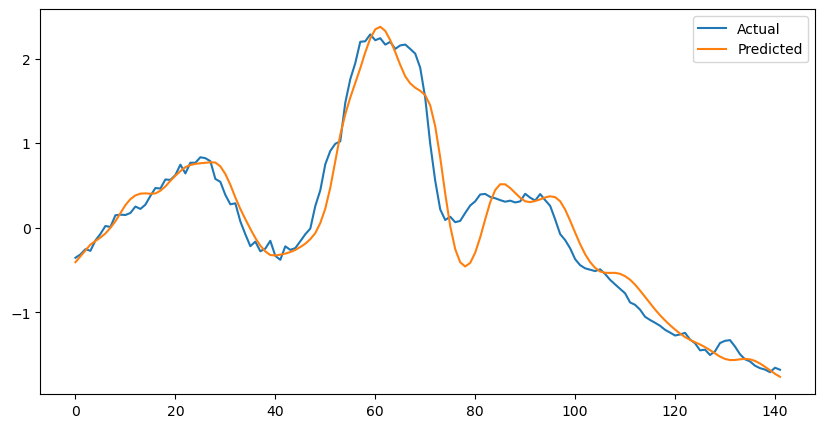

In [11]:
plt.figure(figsize=(10, 5))
plt.plot(train_label_tensor1.cpu().numpy(), label="Actual")
plt.plot(y_pred.cpu().detach().numpy(),label="Predicted")
plt.legend()
plt.show()

## Now let's test on datasets 2, 3, 4

### First create test set 2

In [12]:
normalized_test_2 = (second_piece[:] - second_piece.mean())/second_piece.std()
test_seq_2, test_labels_2 = create_sequences(normalized_test_2.values, 12)
test_tensor_seq_2 = torch.FloatTensor(test_seq_2).to(device='cuda')
test_tensor_labels_2 = torch.FloatTensor(test_labels_2).to(device='cuda')

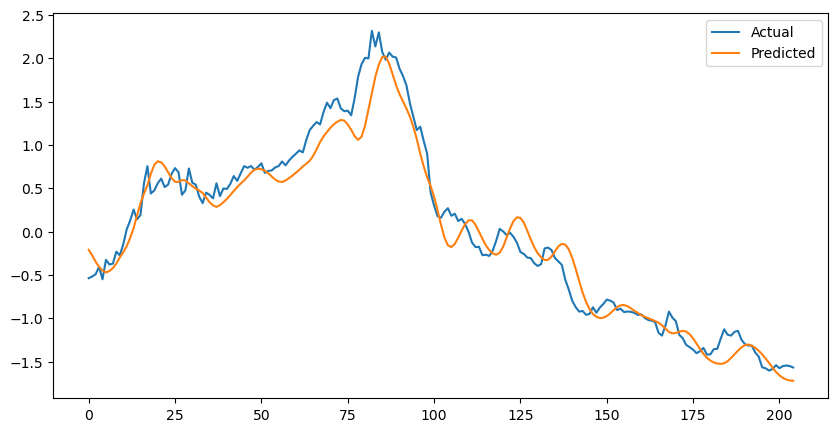

In [13]:
model1.eval()
with torch.no_grad():
    y_pred = model1(test_tensor_seq_2)

plt.figure(figsize=(10, 5))
plt.plot(test_tensor_labels_2.cpu().numpy(), label='Actual')
plt.plot(y_pred.cpu().numpy(), label='Predicted')
plt.legend()
plt.show()

In [14]:
print(f'MARE: {MARE(y_pred, test_tensor_labels_2)}')

MARE: 0.925416886806488


### Now dataset 3

In [15]:
normalized_test_3 = (third_piece[:] - third_piece.mean())/third_piece.std()
test_seq_3, test_labels_3 = create_sequences(normalized_test_3.values, 12)
test_tensor_seq_3 = torch.FloatTensor(test_seq_3).to(device='cuda')
test_tensor_labels_3 = torch.FloatTensor(test_labels_3).to(device='cuda')

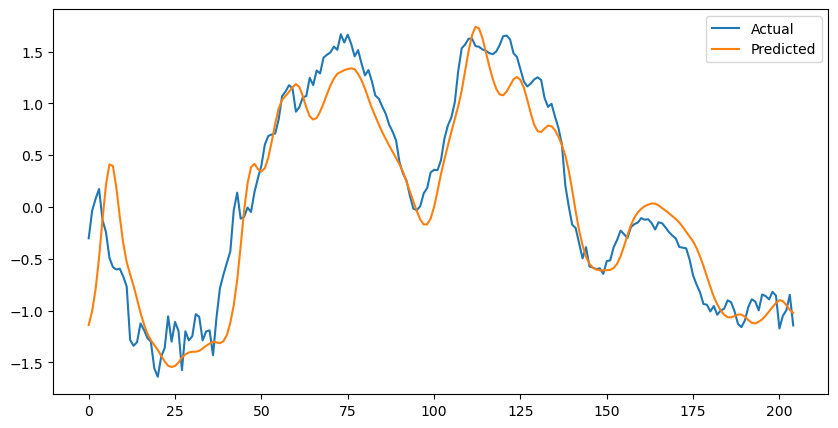

In [16]:
model1.eval()
with torch.no_grad():
    y_pred = model1(test_tensor_seq_3)

plt.figure(figsize=(10, 5))
plt.plot(test_tensor_labels_3.cpu().numpy(), label='Actual')
plt.plot(y_pred.cpu().numpy(), label='Predicted')
plt.legend()
plt.show()

In [17]:
print(f'MARE: {MARE(y_pred, test_tensor_labels_3)}')

MARE: 1.418106198310852


### Finally Dataset 4

In [18]:
normalized_test_4 = (fourth_piece[:] - fourth_piece.mean())/fourth_piece.std()
test_seq_4, test_labels_4 = create_sequences(normalized_test_4.values, 12)
test_tensor_seq_4 = torch.FloatTensor(test_seq_4).to(device='cuda')
test_tensor_labels_4 = torch.FloatTensor(test_labels_4).to(device='cuda')

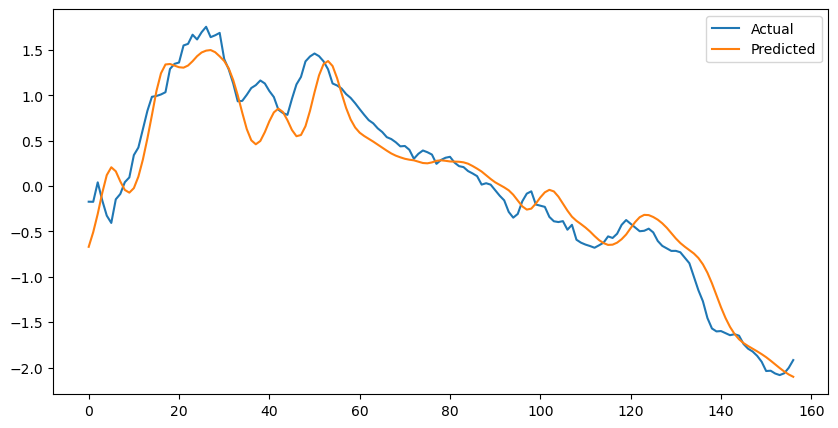

In [19]:
model1.eval()
with torch.no_grad():
    y_pred = model1(test_tensor_seq_4)

plt.figure(figsize=(10, 5))
plt.plot(test_tensor_labels_4.cpu().numpy(), label='Actual')
plt.plot(y_pred.cpu().numpy(), label='Predicted')
plt.legend()
plt.show()

In [20]:
print(f'MARE: {MARE(y_pred, test_tensor_labels_4)}')

MARE: 0.5403726100921631


## Now we train Model 2 on Dataset 2

In [21]:
column_indices = {name: i for i, name in enumerate(first_piece.columns)}
n = len(second_piece)
train_df2 =second_piece[0:int(n*0.8)]
val_df2 = second_piece[int(n*0.8):]

# Normalize the data (each partition separately)
train_mean2 = train_df2.mean()
train_std2 = train_df2.std()

train_df2 = (train_df2 - train_mean2) / train_std2
val_df2 = (val_df2 - train_mean2) / train_std2

# make sequences
train_seq2, train_labels2 = create_sequences(train_df2.values, 12)
val_seq2, val_labels2 = create_sequences(val_df2.values, 12)

# make tensors
train_seq_tensor2 = torch.FloatTensor(train_seq2).to(device='cuda')  # (batch, seq_length, input_dim)
train_label_tensor2 = torch.FloatTensor(train_labels2).to(device='cuda') # (batch, output_dim)
val_seq_tensor2 = torch.FloatTensor(val_seq2).to(device='cuda')  # (batch, seq_length, input_dim)
val_label_tensor2 = torch.FloatTensor(val_labels2).to(device='cuda')  # (batch, output_dim)

In [22]:
model2 = LSTMModel(input_dim, hidden_dim, num_layers, output_dim)
model2 = model2.to("cuda")  # Use "cuda" if you have a GPU
criterion2 = nn.SmoothL1Loss()
optimizer2 = optim.Adam(model2.parameters(), lr=0.0001)

In [23]:
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model2.train()
    
    optimizer2.zero_grad()
    y_pred = model2(train_seq_tensor2)
    
    loss = criterion2(y_pred, train_label_tensor2)
    loss.backward()
    optimizer2.step()
    
    train_losses.append(loss.item())

    # Validation
    model2.eval()
    with torch.no_grad():
        y_val = model2(val_seq_tensor2)
        val_loss = criterion2(y_val, val_label_tensor2)
        val_losses.append(val_loss.item())
    
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Train Loss: {loss.item()}, Val Loss: {val_loss.item()}')


Epoch 0, Train Loss: 0.44896313548088074, Val Loss: 1.5036051273345947


Epoch 10, Train Loss: 0.43558475375175476, Val Loss: 1.4991185665130615
Epoch 20, Train Loss: 0.40622052550315857, Val Loss: 1.434476613998413
Epoch 30, Train Loss: 0.31465885043144226, Val Loss: 1.1846340894699097
Epoch 40, Train Loss: 0.146315798163414, Val Loss: 0.4715844988822937
Epoch 50, Train Loss: 0.1240275502204895, Val Loss: 0.046430256217718124
Epoch 60, Train Loss: 0.09923624992370605, Val Loss: 0.10396784543991089
Epoch 70, Train Loss: 0.0949162021279335, Val Loss: 0.024768177419900894
Epoch 80, Train Loss: 0.09227728098630905, Val Loss: 0.02368738129734993
Epoch 90, Train Loss: 0.08881549537181854, Val Loss: 0.04227869212627411
Epoch 100, Train Loss: 0.08535122126340866, Val Loss: 0.033818069845438004
Epoch 110, Train Loss: 0.08175935596227646, Val Loss: 0.03895033895969391
Epoch 120, Train Loss: 0.07787737250328064, Val Loss: 0.03228950873017311
Epoch 130, Train Loss: 0.07360711693763733, Val Loss: 0.030038589611649513
Epoch 140, Train Loss: 0.06879314035177231, Val Loss

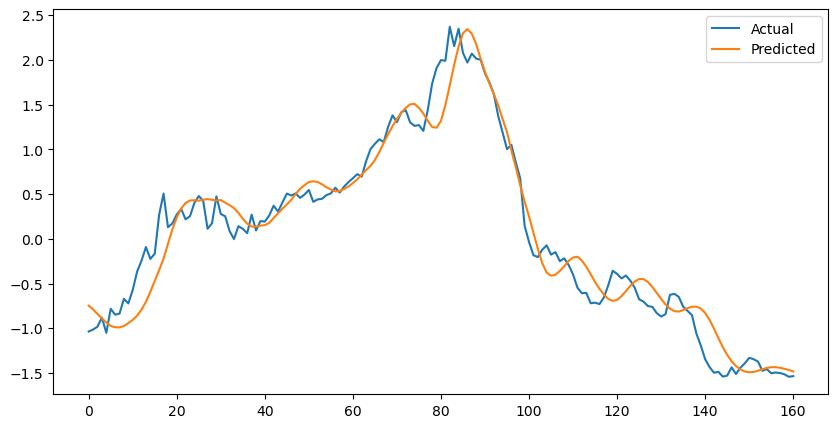

In [24]:
plt.figure(figsize=(10, 5))
plt.plot(train_label_tensor2.cpu().numpy(), label="Actual")
plt.plot(y_pred.cpu().detach().numpy(),label="Predicted")
plt.legend()
plt.show()

### Test on dataset 1

In [25]:
normalized_test_1 = (first_piece[:] - first_piece.mean())/first_piece.std()
test_seq_1, test_labels_1 = create_sequences(normalized_test_1.values, 12)
test_tensor_seq_1 = torch.FloatTensor(test_seq_1).to(device='cuda')
test_tensor_labels_1 = torch.FloatTensor(test_labels_1).to(device='cuda')

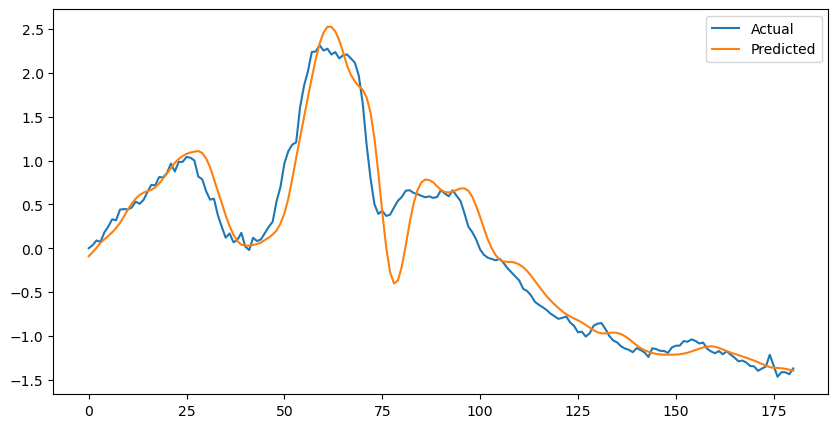

In [26]:
model2.eval()
with torch.no_grad():
    y_pred = model2(test_tensor_seq_1)

plt.figure(figsize=(10,5))
plt.plot(test_tensor_labels_1.cpu().numpy(), label='Actual')
plt.plot(y_pred.cpu().numpy(), label='Predicted')
plt.legend()
plt.show()

In [27]:
print(f'MARE: {MARE(y_pred, test_tensor_labels_1)}')

MARE: 1.365761399269104


### Dataset 3

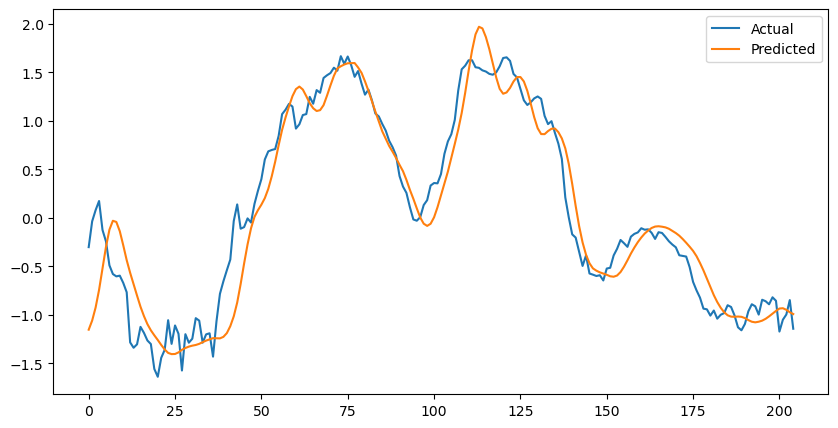

In [29]:
model2.eval()
with torch.no_grad():
    y_pred = model2(test_tensor_seq_3)

plt.figure(figsize=(10, 5))
plt.plot(test_tensor_labels_3.cpu().numpy(), label='Actual')
plt.plot(y_pred.cpu().numpy(), label='Predicted')
plt.legend()
plt.show()

In [ ]:
print(f'MARE: {MARE(y_pred, test_tensor_labels_3)}')

### Dataset 4

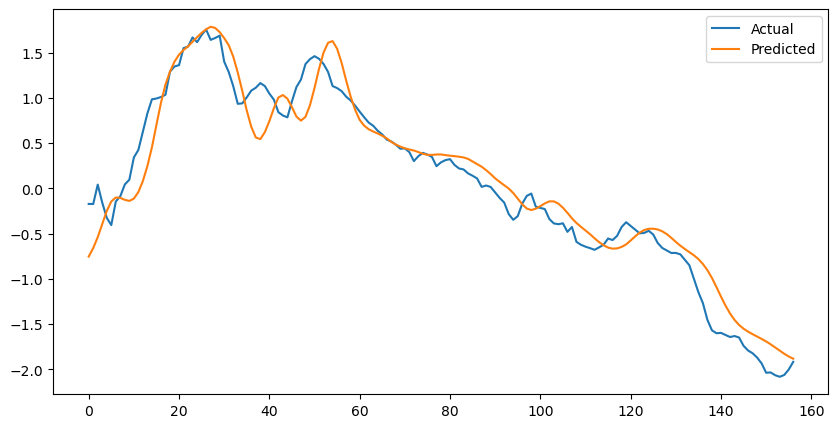

In [30]:
model2.eval()
with torch.no_grad():
    y_pred = model2(test_tensor_seq_4)

plt.figure(figsize=(10, 5))
plt.plot(test_tensor_labels_4.cpu().numpy(), label='Actual')
plt.plot(y_pred.cpu().numpy(), label='Predicted')
plt.legend()
plt.show()

In [31]:
print(f'MARE: {MARE(y_pred, test_tensor_labels_4)}')

MARE: 0.6731029152870178


### Now train Model 3 on dataset 3

In [32]:
column_indices = {name: i for i, name in enumerate(first_piece.columns)}
n = len(third_piece)
train_df3 =third_piece[0:int(n*0.8)]
val_df3 = third_piece[int(n*0.8):]

# Normalize the data (each partition separately)
train_mean3 = train_df3.mean()
train_std3 = train_df3.std()

train_df3 = (train_df3 - train_mean3) / train_std3
val_df3 = (val_df3 - train_mean3) / train_std3

# make sequences
train_seq3, train_labels3 = create_sequences(train_df3.values, 12)
val_seq3, val_labels3 = create_sequences(val_df3.values, 12)

# make tensors
train_seq_tensor3 = torch.FloatTensor(train_seq3).to(device='cuda')  # (batch, seq_length, input_dim)
train_label_tensor3 = torch.FloatTensor(train_labels3).to(device='cuda') # (batch, output_dim)
val_seq_tensor3 = torch.FloatTensor(val_seq3).to(device='cuda')  # (batch, seq_length, input_dim)
val_label_tensor3 = torch.FloatTensor(val_labels3).to(device='cuda')  # (batch, output_dim)

In [35]:
model3 = LSTMModel(input_dim, hidden_dim, num_layers, output_dim)
model3 = model3.to(device='cuda')
optimizer3 = torch.optim.Adam(model3.parameters(), lr=1e-4)
criterion3 = nn.SmoothL1Loss()

In [38]:
train_losses = []
val_losses = []
for epoch in range(num_epochs):
    model3.train()

    optimizer3.zero_grad()
    y_pred = model3(train_seq_tensor3)

    loss = criterion3(y_pred, train_label_tensor3)
    loss.backward()
    optimizer3.step()
    train_losses.append(loss.item())

    # Validation
    model3.eval()
    with torch.no_grad():
        y_val = model3(val_seq_tensor3)
        val_loss = criterion3(y_val, val_label_tensor3)
        val_losses.append(val_loss.item())
    
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Train Loss: {loss.item()}, Val Loss: {val_loss.item()}')


Epoch 0, Train Loss: 0.032906778156757355, Val Loss: 0.024656925350427628
Epoch 10, Train Loss: 0.031724583357572556, Val Loss: 0.023540599271655083
Epoch 20, Train Loss: 0.030510153621435165, Val Loss: 0.022214248776435852
Epoch 30, Train Loss: 0.02925773710012436, Val Loss: 0.020819474011659622
Epoch 40, Train Loss: 0.02793910913169384, Val Loss: 0.019496608525514603
Epoch 50, Train Loss: 0.026521455496549606, Val Loss: 0.018120914697647095
Epoch 60, Train Loss: 0.024966750293970108, Val Loss: 0.016551658511161804
Epoch 70, Train Loss: 0.02323676086962223, Val Loss: 0.014736922457814217
Epoch 80, Train Loss: 0.021350780501961708, Val Loss: 0.012672251090407372
Epoch 90, Train Loss: 0.019555451348423958, Val Loss: 0.010642156936228275
Epoch 100, Train Loss: 0.019180025905370712, Val Loss: 0.009036130271852016
Epoch 110, Train Loss: 0.01782107539474964, Val Loss: 0.008246498182415962
Epoch 120, Train Loss: 0.016979755833745003, Val Loss: 0.008337099105119705
Epoch 130, Train Loss: 0.01

### Test on dataset 1

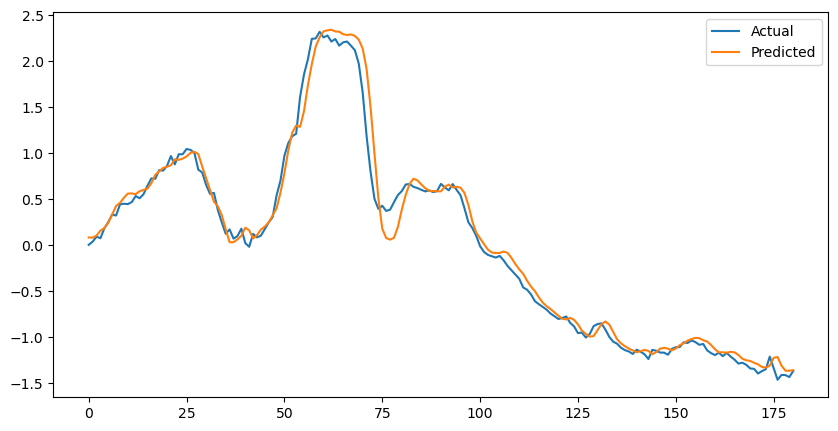

In [39]:
model3.eval()
with torch.no_grad():
    y_pred = model3(test_tensor_seq_1)

plt.figure(figsize=(10, 5))
plt.plot(test_tensor_labels_1.cpu().numpy(), label='Actual')
plt.plot(y_pred.cpu().numpy(), label='Predicted')
plt.legend()
plt.show()

In [40]:
print(f'MARE: {MARE(y_pred, test_tensor_labels_1)}')

MARE: 1.0562549829483032


### Test on dataset 2

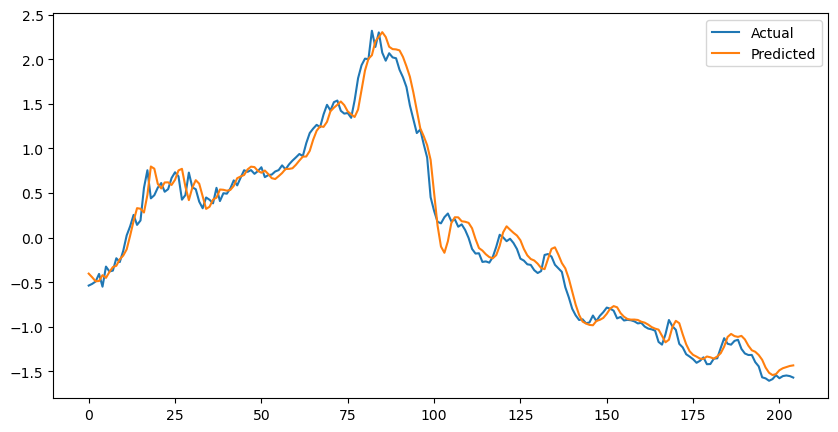

In [41]:
model3.eval()
with torch.no_grad():
    y_pred = model3(test_tensor_seq_2)

plt.figure(figsize=(10, 5))
plt.plot(test_tensor_labels_2.cpu().numpy(), label='Actual')
plt.plot(y_pred.cpu().numpy(), label='Predicted')
plt.legend()
plt.show()

In [42]:
print(f'MARE: {MARE(y_pred, test_tensor_labels_2)}')

MARE: 0.649273157119751


### Test on dataset 4

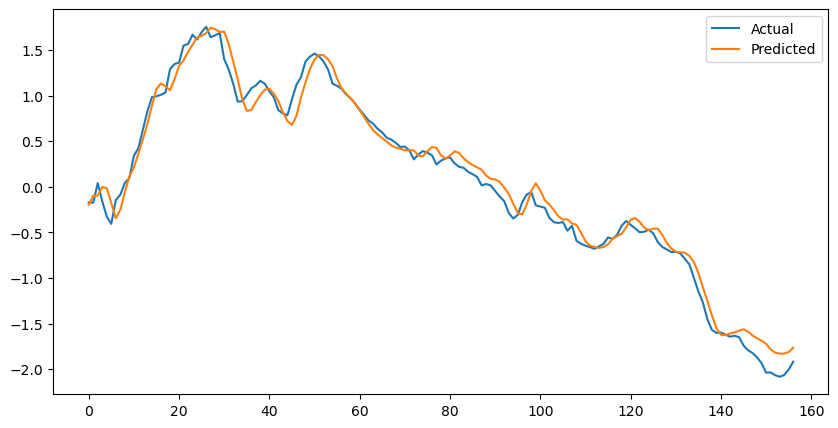

In [43]:
model3.eval()
with torch.no_grad():
    y_pred = model3(test_tensor_seq_4)

plt.figure(figsize=(10, 5))
plt.plot(test_tensor_labels_4.cpu().numpy(), label='Actual')
plt.plot(y_pred.cpu().numpy(), label='Predicted')
plt.legend()
plt.show()

In [44]:
print(f'MARE: {MARE(y_pred, test_tensor_labels_4)}')

MARE: 0.3834322988986969


## Train model 4 on dataset 4

In [47]:
column_indices = {name: i for i, name in enumerate(first_piece.columns)}
n = len(fourth_piece)
train_df4 =fourth_piece[0:int(n*0.8)]
val_df4 = fourth_piece[int(n*0.8):]

# Normalize the data (each partition separately)
train_mean4 = train_df4.mean()
train_std4 = train_df4.std()

train_df4 = (train_df4 - train_mean4) / train_std4
val_df4 = (val_df4 - train_mean4) / train_std4

# make sequences
train_seq4, train_labels4 = create_sequences(train_df4.values, 12)
val_seq4, val_labels4 = create_sequences(val_df4.values, 12)

# make tensors
train_seq_tensor4 = torch.FloatTensor(train_seq4).to(device='cuda')  # (batch, seq_length, input_dim)
train_label_tensor4 = torch.FloatTensor(train_labels4).to(device='cuda') # (batch, output_dim)
val_seq_tensor4 = torch.FloatTensor(val_seq4).to(device='cuda')  # (batch, seq_length, input_dim)
val_label_tensor4 = torch.FloatTensor(val_labels4).to(device='cuda')  # (batch, output_dim)

In [49]:
model4 = LSTMModel(input_dim, hidden_dim, num_layers, output_dim)
criterion4 = nn.SmoothL1Loss()
optimizer4 = optim.Adam(model4.parameters(), lr=1e-4)
model4.to(device='cuda')

LSTMModel(
  (lstm): LSTM(1, 256, num_layers=3, batch_first=True)
  (fc): Linear(in_features=256, out_features=1, bias=True)
)

In [52]:
train_losses = []
val_losses = []
for epoch in range(num_epochs):
    model4.train()
    optimizer4.zero_grad()
    y_pred = model4(train_seq_tensor4)

    loss = criterion4(y_pred, train_label_tensor4)
    train_losses.append(loss.item())
    loss.backward()
    optimizer4.step()

    # Validation
    model4.eval()
    with torch.no_grad():
        y_val = model4(val_seq_tensor4)
    val_loss = criterion4(y_val, val_label_tensor4)
    val_losses.append(val_loss.item())

    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Train Loss: {loss.item()}, Val Loss: {val_loss.item()}')

Epoch 0, Train Loss: 0.035739921033382416, Val Loss: 0.22808444499969482
Epoch 10, Train Loss: 0.03404447063803673, Val Loss: 0.22989915311336517
Epoch 20, Train Loss: 0.0324789360165596, Val Loss: 0.25510042905807495
Epoch 30, Train Loss: 0.030891871079802513, Val Loss: 0.2930164933204651
Epoch 40, Train Loss: 0.02926824986934662, Val Loss: 0.3285655975341797
Epoch 50, Train Loss: 0.02755836956202984, Val Loss: 0.3548809885978699
Epoch 60, Train Loss: 0.025707757100462914, Val Loss: 0.37317341566085815
Epoch 70, Train Loss: 0.02364245057106018, Val Loss: 0.3824753761291504
Epoch 80, Train Loss: 0.021298566833138466, Val Loss: 0.37762725353240967
Epoch 90, Train Loss: 0.018734939396381378, Val Loss: 0.349703848361969
Epoch 100, Train Loss: 0.018273774534463882, Val Loss: 0.2811293601989746
Epoch 110, Train Loss: 0.015147208236157894, Val Loss: 0.2416118085384369
Epoch 120, Train Loss: 0.013915052637457848, Val Loss: 0.2150876373052597
Epoch 130, Train Loss: 0.012796666473150253, Val Lo

### Test on dataset 1

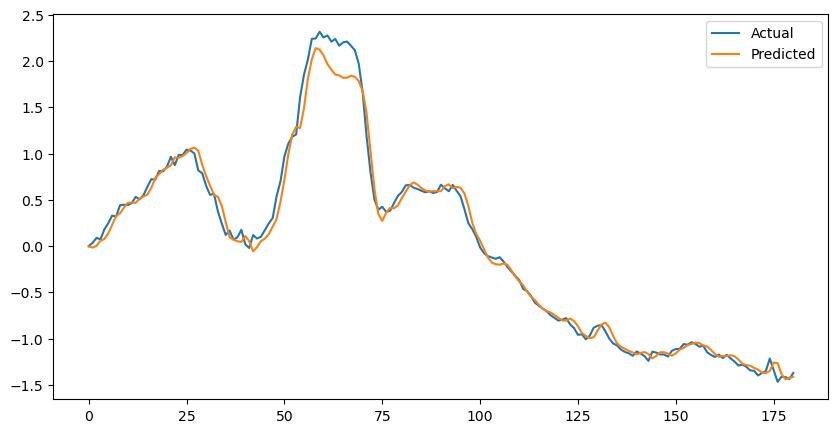

In [53]:
model4.eval()
with torch.no_grad():
    y_pred = model4(test_tensor_seq_1)

plt.figure(figsize=(10, 5))
plt.plot(test_tensor_labels_1.cpu().numpy(), label='Actual')
plt.plot(y_pred.cpu().numpy(), label='Predicted')
plt.legend()
plt.show()

In [54]:
print(f'MARE: {MARE(y_pred, test_tensor_labels_1)}')

MARE: 0.2623833417892456


### Test on dataset 2

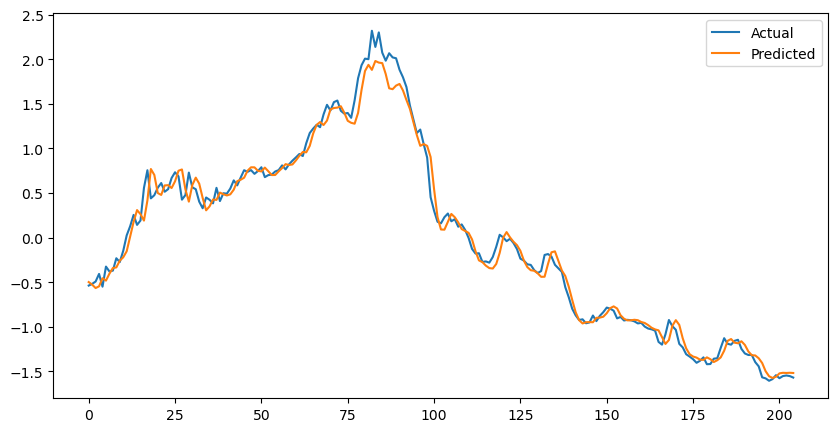

In [55]:
model4.eval()
with torch.no_grad():
    y_pred = model4(test_tensor_seq_2)

plt.figure(figsize=(10, 5))
plt.plot(test_tensor_labels_2.cpu().numpy(), label='Actual')
plt.plot(y_pred.cpu().numpy(), label='Predicted')
plt.legend()
plt.show()

In [56]:
print(f'MARE: {MARE(y_pred, test_tensor_labels_2)}')

MARE: 0.32866230607032776


### Test on dataset 3

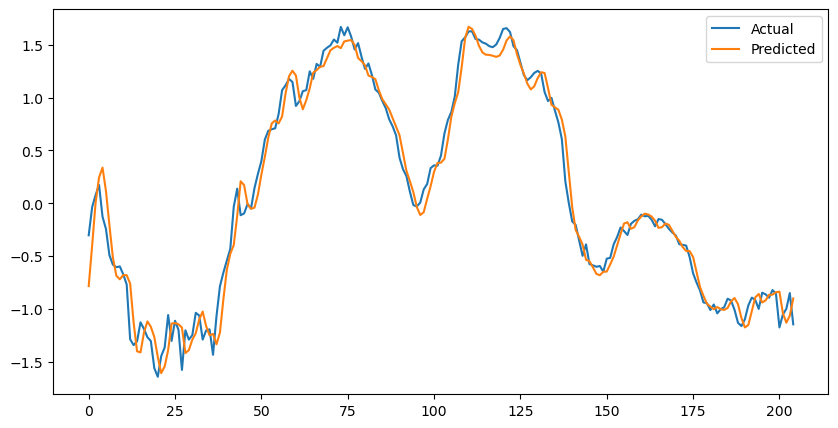

In [57]:
model4.eval()
with torch.no_grad():
    y_pred = model4(test_tensor_seq_3)

plt.figure(figsize=(10, 5))
plt.plot(test_tensor_labels_3.cpu().numpy(), label='Actual')
plt.plot(y_pred.cpu().numpy(), label='Predicted')
plt.legend()
plt.show()

In [58]:
print(f'MARE: {MARE(y_pred, test_tensor_labels_3)}')

MARE: 0.7290813326835632
